# DSCI 100 Group 30 Project Proposal - Heart Disease Analysis

## Introduction

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We first download the data from Kaggle (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset) to the notebook folder, and read the dataset using relative path. 

In [2]:
data <- read_csv("heart.csv")

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


The datasets is already in a tidy version, we split it into training and testing datasets

In [4]:
data <- data |>
    mutate(target = as_factor(target)) |>
    mutate(sex = as_factor(sex))

In [5]:
#Split into training and testing datasets
heart_split <- initial_split(data, prop = 0.75, strata = target)  
training_set <- training(heart_split)   
testing_set <- testing(heart_split)

In [6]:
#Check if there are missing values or not
identical(training_set, na.omit(training_set))

[1] TRUE

Since the datasets are the same before and after dropping the missing (NA) values, we can say that there are no missing values in the training set. Then, we create some summarize tables to demonstrate our dataset:

In [7]:
#The mean value for each potantial predictors
mean_predictors <- training_set |>
    select(age, cp:thal) |>
    map_df(mean)
mean_predictors

age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.67057,0.9518229,132.2773,245.4245,0.1523438,0.5104167,149.0807,0.3255208,1.101953,1.373698,0.7226562,2.333333


In [8]:
#Number of diseases
disease <- training_set |>
    filter(target == 1) |>
    mutate(target == "disease")

no_disease <- training_set |>
    filter(target == 0) |>
    mutate(target == "no_disease")

data.frame(disease = nrow(disease),
           no_disease = nrow(no_disease))

disease,no_disease
<int>,<int>
394,374


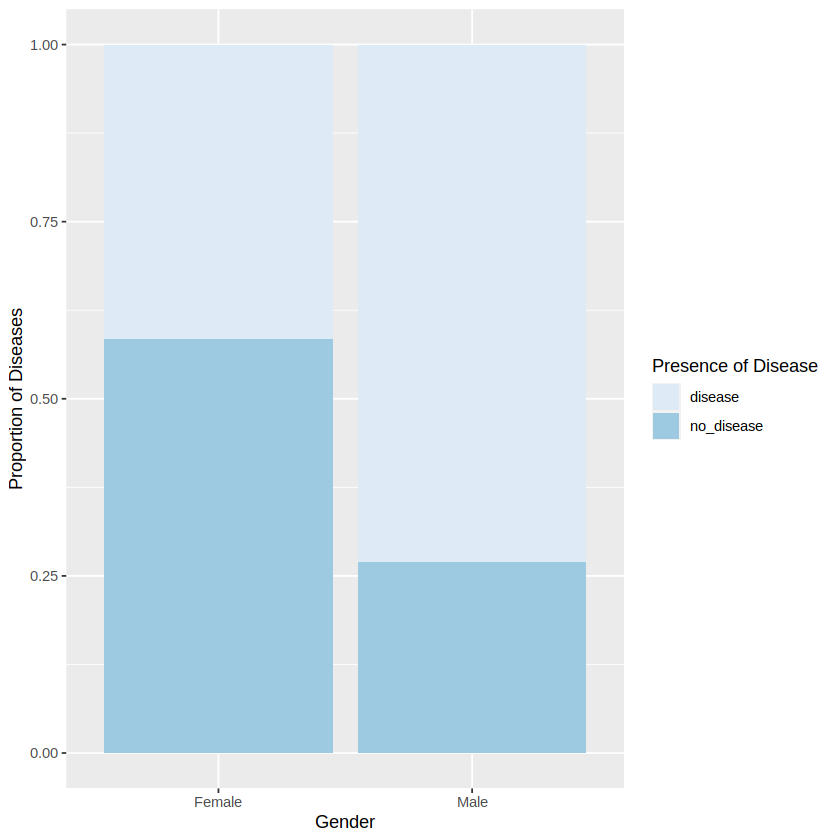

In [16]:
heart_plot_sex <- training_set |>
    mutate(sex = ifelse(sex == 0, "Male", "Female")) |>
    mutate(target = ifelse(target == 0, "no_disease","disease")) |>
    ggplot(aes(x=sex, fill=target)) + 
    geom_bar(position = 'fill') + 
    labs(x = "Gender",y = "Proportion of Diseases",fill = "Presence of Disease") +
    scale_fill_brewer()
heart_plot_sex

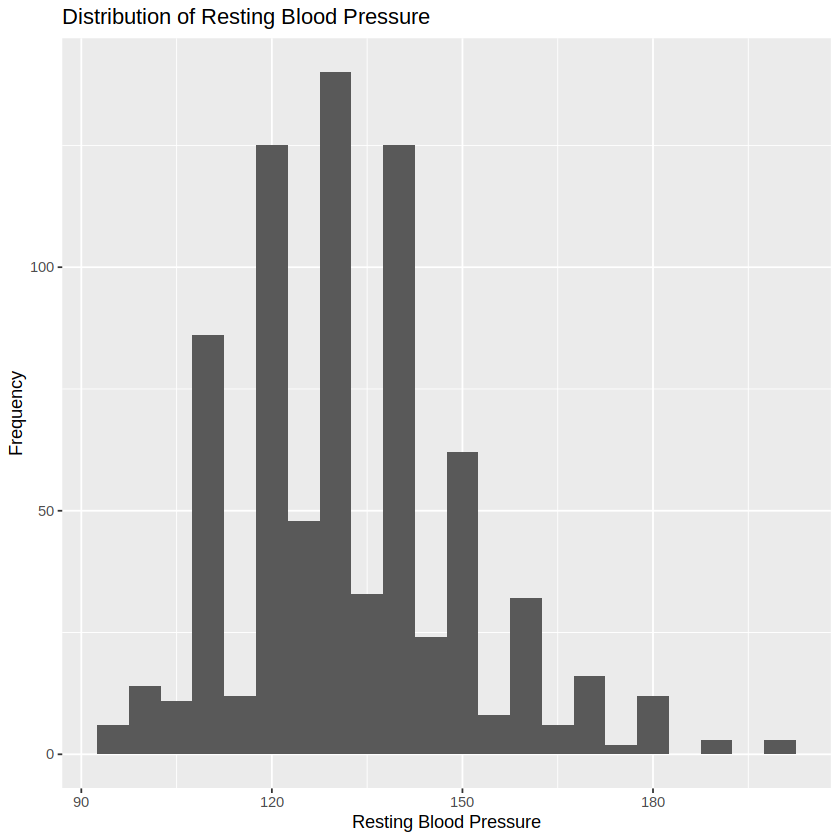

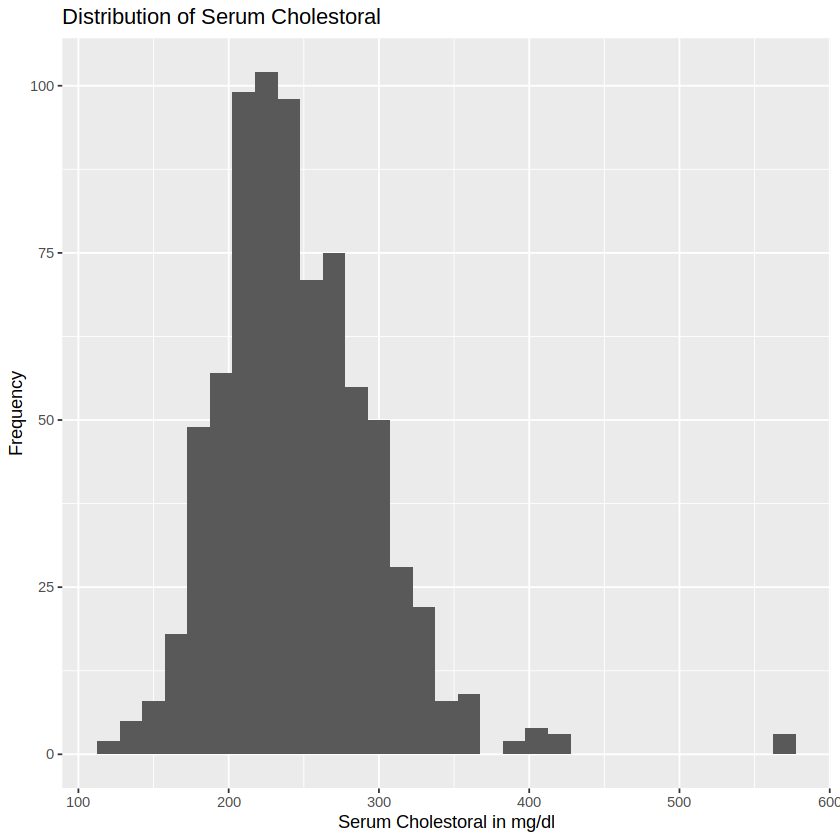

In [20]:
rbp_distribution_plot <- training_set |> 
    ggplot(aes(x = trestbps)) +
    geom_histogram(binwidth = 5) +
    labs(title = "Distribution of Resting Blood Pressure", x = "Resting Blood Pressure", y = "Frequency")
chol_distribution_plot <- training_set |> 
    ggplot(aes(x = chol)) +
    geom_histogram(binwidth = 15) +
    labs(title = "Distribution of Serum Cholestoral", x = "Serum Cholestoral in mg/dl", y = "Frequency")
rbp_distribution_plot
chol_distribution_plot

## Methods

## Expected outcomes and significance